In [1]:
import pyprob
import itertools
from pyprob import Model, InferenceEngine
from pyprob.distributions import Uniform, Normal, Categorical, Poisson
from pyprob.util import to_variable, to_numpy

import torch
import math
import numpy as np
import scipy
import scipy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
colors = [cm.inferno(x) for x in np.linspace(0, 1, 5)]
%matplotlib inline

## Sherpa dummy

In [2]:
custom_pdf = lambda x, scale: 1/scale*np.abs(x/scale)
def rejection_sample(scale):
    ymax = custom_pdf(scale,scale)

    ntries = 0
    while True:
        ntries  = ntries+1
        xtest   = pyprob.sample(Uniform(-scale, scale), control=False).data.cpu().numpy()
        ysample = pyprob.sample(Uniform(0, ymax), control=False).data.cpu().numpy()
        if ysample < custom_pdf(xtest,scale):
            return xtest, ntries

def M(axis, theta):
    return la.expm(np.cross(np.eye(3), axis/la.norm(axis)*theta))

def rotations(phi,theta):
    M1 = M([0,0,1], phi)
    M2 = M([0,1,0], theta)
    return lambda v: np.dot(M2, np.dot(M1,v)), lambda v: np.dot(la.inv(M1),np.dot(la.inv(M2),v))
    
def to_polar(v):
    x,y,z = v
    r, phi = la.norm(v), np.arctan2(y,x)
    theta = np.arccos(z/r)
    return r, phi, theta

def align(v):
    x,y,z = v
    r, phi, theta = to_polar(v)
    forward, backward = rotations(-phi,-theta)
    aligned =forward(v)
    return forward, backward

def split(v, theta, phi, first_norm):
    fwd, back = align(v)
    a = fwd(v)
    d1 = rotations(-phi,-theta)[1](a*first_norm/np.cos(theta))
    d2 = a - d1
    return  back(d1),  back(d2)

def split_n(v,n):
    splits = []
    rest = v

    thetas = [rejection_sample(scale = np.pi/4)[0] for i in range(n-1)]
    phis   = [pyprob.sample(Uniform(0, 2*np.pi), control=False).data.cpu().numpy() for i in range(n-1)]

    for i,(theta,phi) in enumerate(zip(thetas, phis)):
        norm = 1./(n-i)
        a, rest = split(rest, theta, phi, first_norm = norm)
        splits.append(a)
    splits.append(rest)
    return splits

def shower_pars(v, surface_z):
    scaled = (surface_z/v[2])*np.asarray(v)
    loc = scaled[:2]
    sigmas = [1,1]
    return loc, sigmas

def deposit(v, surface_z, single_dep):
    loc, sigmas = shower_pars(v, surface_z)
    if v[2] < 0:
        print('wrong direction')
    if v[2] > 0:
        ndeps = int(la.norm(v)/single_dep)
        return pyprob.sample(Normal([loc for i in range(ndeps)], [sigmas for i in range(ndeps)]), control=False).data.cpu().numpy()
    else:
        return np.empty([0, 2])

    
def multivar_norm_pdf(x,mean,cov):
    x, mean, cov = np.asarray(x), np.asarray(mean), np.asarray(cov)
    expv = ((x-mean).dot(np.linalg.inv(cov).dot(x-mean)))
    return np.exp(-0.5*expv)/np.sqrt((np.power(2*np.pi,len(x)))*np.linalg.det(cov))

def mean_vals(bincnt, binvol, ener, sfra, locs, covs):
    ws = [E*sf for E,sf in zip(ener,sfra)]
    weights = []
    v = None
    vps = []
    for loc, cov, E, sf in zip(locs, covs, sfra, ener):
        w = E*sf
#         vp = np.asarray([multivar_norm_pdf(bc, loc, cov) for bc in bincnt])
        vp = scipy.stats.multivariate_normal(mean = loc, cov = cov).pdf(bincnt)
        vps.append(vp)
        v = w*vp if v is None else v + w*vp
        weights.append(w)
    v  = v / np.sum(weights)
    v  = v * np.sum(weights) * binvol
    return vps, v

In [6]:
def bin_centers_and_vol(binedges):
    widths  = []
    centers = []
    for axis in binedges:
        axwidths = axis[1:]-axis[:-1]
        assert np.all(axwidths == axwidths[0])
        axcenters = axis[:-1]+axwidths/2
        widths.append(axwidths)
        centers.append(axcenters)
    points = []
    for x,y in itertools.product(*centers):
        points.append([x,y])
    points = np.asarray(points)
    return points, np.prod(widths)


class SherpaDummy(Model):
    def __init__(self, binning=[np.linspace(-10,10,21),np.linspace(-10,10,21)], surface_z=3, singledep=0.01):
        self._binning   = binning
        self._singledep = singledep 
        self._bincenters , self._binvol = bin_centers_and_vol(self._binning)

        self._surface_z = surface_z
#         self._likelihood_stddev = likelihood_stddev
        super().__init__('Sherpa dummy in Python')

    def stochastic_calo(self, final_state_momenta):
        deps = [deposit(v,self._surface_z, self._singledep) for v in final_state_momenta]
        alldeps = np.concatenate(deps)
        calo_histo,xe,ye = np.histogram2d(alldeps[:,0],alldeps[:,1], bins = self._binning)
        calo_histo = calo_histo*self._singledep
        return calo_histo, deps

    def deterministic_calo(self, final_state_momenta, nx, ny):
        sp        = [shower_pars(v, self._surface_z) for v in final_state_momenta]
        locs      = [p[0] for p in sp]
        covs      = [np.square(np.diag(p[1])) for p in sp]
        energies  = [la.norm(v) for v in final_state_momenta]
        sampfracs = [1. for v in final_state_momenta]

        _, smooth = mean_vals(self._bincenters, self._binvol, energies, sampfracs, locs, covs)
        smoothMesh = np.asarray(smooth).T.reshape(ny,nx)
        return smoothMesh

    def forward(self, observation=torch.zeros(20*20)):
        channel = pyprob.sample(Categorical([1/3, 1/3, 1/3])).float() + 1
        mother_momentum = [pyprob.sample(Uniform(-0.5,0.5)),pyprob.sample(Uniform(-0.5,0.5)),pyprob.sample(Uniform(10,20))]
        final_state_momenta = split_n(list(map(float, mother_momentum)), int(channel))

        smoothMesh = self.deterministic_calo(final_state_momenta, nx = len(self._binning[0])-1, ny = len(self._binning[1])-1)
        mean_n_deposits = to_variable(smoothMesh  / self._singledep)
        obs_n_deposits  = to_variable(np.rint(to_numpy(observation) / self._singledep))
#         print(float(torch.sum(mean_n_deposits)), float(torch.sum(obs_n_deposits)))

        likelihood = Poisson(mean_n_deposits.view(-1))
        pyprob.observe(likelihood, obs_n_deposits.view(-1))

        return torch.cat(mother_momentum), channel, to_variable(final_state_momenta), mean_n_deposits

model = SherpaDummy()        

1520.5719


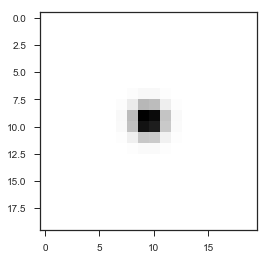

In [12]:
fwd = model.forward()
f, ax1 = plt.subplots(1,1)
b = to_numpy(fwd[-1])
# ax1.imshow(a)
ax1.imshow(b)
print(np.sum(b))

## Plotting code

In [13]:
def plot_distribution(dist, plot_samples=50000, title='', ground_truths=None, file_name=None):
    dist_px = dist.map(lambda x: float(x[0][0]))
    dist_py = dist.map(lambda x: float(x[0][1]))
    dist_pz = dist.map(lambda x: float(x[0][2]))
    dist_channel = dist.map(lambda x: int(x[1]))
    dist_px_samples = [dist_px.sample() for i in range(plot_samples)]
    dist_py_samples = [dist_py.sample() for i in range(plot_samples)]
    dist_pz_samples = [dist_pz.sample() for i in range(plot_samples)]
    dist_channel_samples = [dist_channel.sample() for i in range(plot_samples)]

    dist_channel_combined = pyprob.distributions.Empirical(dist_channel.values, weights=dist_channel.weights, combine_duplicates=True)
    dist_channel_combined_values = dist_channel_combined.values
    dist_channel_combined_weights = [float(w) for w in dist_channel_combined.weights]
    dist_channel_str = 'channels: ' + ', '.join(['{}: {:.3f}'.format(v, w) for v, w in zip(dist_channel_combined_values, dist_channel_combined_weights)])
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
    plt.suptitle(title, y = 1.1)
    ax1.title.set_text('Channel')
    ax1.text(0.5, -0.3, 'mean={:.3f} (solid), stddev={:.3f}'.format(float(dist_channel.mean), float(dist_channel.stddev)))
    ax1.text(0.5, -0.4, dist_channel_str)
    ax2.title.set_text('p_x')
    ax2.text(-0.5, -15, 'mean={:.3f} (solid), stddev={:.3f}'.format(float(dist_px.mean), float(dist_px.stddev)))
    ax3.title.set_text('p_y')
    ax3.text(-0.5, -15, 'mean={:.3f} (solid), stddev={:.3f}'.format(float(dist_py.mean), float(dist_py.stddev)))
    ax4.title.set_text('p_z')
    ax4.text(10, -1.5, 'mean={:.3f} (solid), stddev={:.3f}'.format(float(dist_pz.mean), float(dist_pz.stddev)))

    _ = ax1.hist(dist_channel_samples, bins=[0.5,1.5,2.5,3.5], density=True, alpha=0.75, color=colors[0])
    ax1.set_xlim([0.5,3.5])
    ax1.set_ylim([0,1])
    ax1.set_xticks([1,2,3])
    ax1.axvline(float(dist_channel.mean), color='gray', linestyle='solid', linewidth=1)    
    _ = ax2.hist(dist_px_samples, bins=np.arange(-0.5,0.5+0.02,0.02), density=True, alpha=0.75, color=colors[1])
    ax2.set_xlim([-0.5,0.5])
    ax2.set_ylim([0,50])
    ax2.axvline(float(dist_px.mean), color='gray', linestyle='solid', linewidth=1)    
    _ = ax3.hist(dist_py_samples, bins=np.arange(-0.5,0.5+0.02,0.02), density=True, alpha=0.75, color=colors[2])
    ax3.set_xlim([-0.5,0.5])
    ax3.set_ylim([0,50])
    ax3.axvline(float(dist_py.mean), color='gray', linestyle='solid', linewidth=1)    
    _ = ax4.hist(dist_pz_samples, bins=np.arange(10,20+0.2,0.2), density=True, alpha=0.75, color=colors[3])
    ax4.set_xlim([10,20])
    ax4.set_ylim([0,5])
    ax4.axvline(float(dist_pz.mean), color='gray', linestyle='solid', linewidth=1)    
    if ground_truths is not None:
        ax1.axvline(float(ground_truths[0]), color='gray', linestyle='dashed', linewidth=2)
        ax2.axvline(float(ground_truths[1]), color='gray', linestyle='dashed', linewidth=2)
        ax3.axvline(float(ground_truths[2]), color='gray', linestyle='dashed', linewidth=2)
        ax4.axvline(float(ground_truths[3]), color='gray', linestyle='dashed', linewidth=2)

        ax1.text(0.5, -0.2, 'ground_truth={:.3f} (dashed)'.format(float(ground_truths[0])))
        ax2.text(-0.5, -10, 'ground_truth={:.3f} (dashed)'.format(float(ground_truths[1])))
        ax3.text(-0.5, -10, 'ground_truth={:.3f} (dashed)'.format(float(ground_truths[2])))
        ax4.text(10, -1, 'ground_truth={:.3f} (dashed)'.format(float(ground_truths[3])))

    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')
    
def plot_trace(trace, file_name=None):
    data = (trace.samples_observed[0].distribution.sample() * model._singledep).view(20,20).data.cpu().numpy()
    data_flat = data.reshape(-1)
    non_zero = np.count_nonzero(data_flat)
    data_flat_min = min(data_flat)
    data_flat_max = max(data_flat)

    particles = trace.result[2].view(-1,3)
    deps = trace.result[3]
    final_state_momenta = trace.result[2].data.cpu().numpy()
    
    trace_text = [str(trace),
                 '\nlatents',
                 'p_x      : {}'.format(float(trace.result[0][0])),
                 'p_y      : {}'.format(float(trace.result[0][1])),
                 'p_z      : {}'.format(float(trace.result[0][2])),
                 'channel  : {}'.format(int(trace.result[1])),
                 'particles: {}'.format(particles.size(0)),
                 str(particles),
                 'calorimeter',
                 'non-zero pixels: {}/{} ({:.2f}%)'.format(non_zero, len(data_flat), 100*non_zero/len(data_flat)),
                 'min   : {:.3f}'.format(data_flat_min),
                 'max   : {:.3f}'.format(data_flat_max),
                 'total : {:.3f}'.format(np.sum(data_flat))]
    trace_text = '\n'.join(trace_text)
#     print(trace_text)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    colors = ['r','b','g','y','k']
    
#     for d,c in zip(deps,colors):
#         ax1.scatter(d[:,0],d[:,1], c = c, alpha = 0.2, s = 10)

    ax1.text(-10, 15, trace_text)
    ax1.set_xlim(-10,10)
    ax1.set_ylim(-10,10)
    ticks = [-10,-5,0,5,10]
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    xc,yc = np.meshgrid(*model._binning)
    ax2.pcolor(xc,yc,data.T,cmap='viridis')
    ax2.set_xticks(ticks)
    ax2.set_yticks(ticks)
    
    ax3.set_axis_off()
    ax3 = fig.add_subplot(1,3,3, projection='3d')
    for v,c in zip(final_state_momenta,colors):
        traj = np.array([(np.asarray(v)*t).tolist() for t in np.linspace(0,abs(model._surface_z*1.5/v[2]))])
        ax3.plot(traj[:,0],traj[:,1],traj[:,2], c = c)
    ax3.set_zlim(0,model._surface_z)
    ax3.set_xlim(-10,10)
    ax3.set_ylim(-10,10)
    ax3.set_xticks(ticks)
    ax3.set_yticks(ticks)    
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.plot_surface(xc,yc,np.ones_like(xc)*model._surface_z, cstride=1, rstride=1, facecolors = plt.cm.viridis(data.T/np.max(data.T)), shade=False)
    ax3.view_init(45,-45)
    
    if file_name is not None:
        plt.savefig(file_name, bbox_inches='tight')    

## Prior distribution

In [14]:
prior_dist = model.prior_distribution(num_traces=1000, prior_inflation=pyprob.PriorInflation.DISABLED)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 1000/1000 | 303.64       


Marginalize

In [15]:
prior_dist_px = prior_dist.map(lambda x: float(x[0][0]))
prior_dist_py = prior_dist.map(lambda x: float(x[0][1]))
prior_dist_pz = prior_dist.map(lambda x: float(x[0][2]))
prior_dist_channel = prior_dist.map(lambda x: int(x[1]))

We can compute expectations under any distribution (prior or posterior):

In [16]:
prior_dist_pz.expectation(lambda x: math.sin(x)/x)

Variable containing:
1.00000e-03 *
 -8.7170
[torch.FloatTensor of size 1]

We can also sample from these distributions, and inspect values and weights.

In [17]:
prior_dist_pz.sample()

15.900388717651367

In [18]:
prior_dist_channel.values[:10]

[1, 2, 3, 1, 3, 3, 2, 3, 1, 2]

In [19]:
prior_dist_channel.weights[:10]

Variable containing:
1.00000e-03 *
  1.0000
  1.0000
  1.0000
  1.0000
  1.0000
  1.0000
  1.0000
  1.0000
  1.0000
  1.0000
[torch.FloatTensor of size 10]

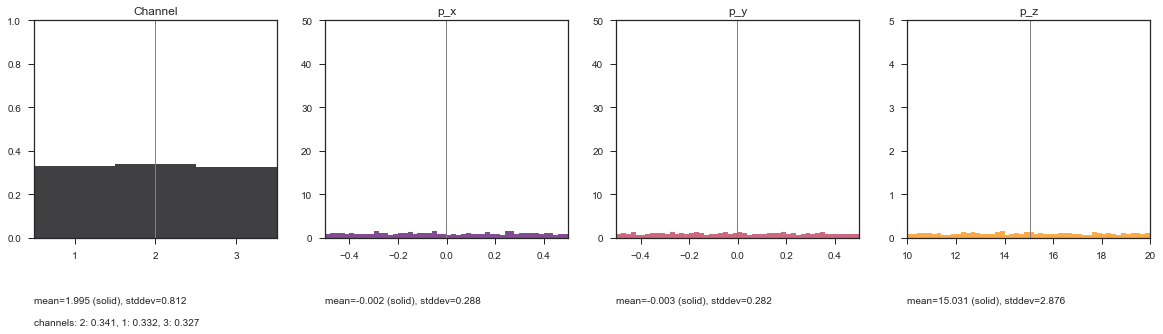

In [20]:
plot_distribution(prior_dist)

Sample a trace and plot it.

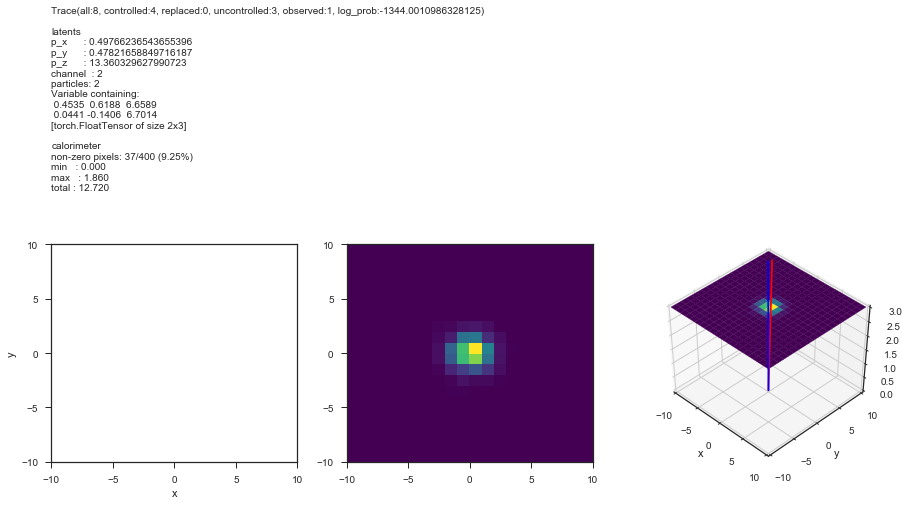

In [21]:
trace = next(model._trace_generator())
plot_trace(trace)

# Inference

In [22]:
def infer(ground_truth_trace, num_traces=10, inference_engine=InferenceEngine.IMPORTANCE_SAMPLING):
    observation = ground_truth_trace.samples_observed[0].distribution.mean * model._singledep
    posterior = model.posterior_distribution(num_traces, inference_engine, observation=observation)
    return posterior

## Inference with Metropolis Hastings

We run inference with single-site Metropolis Hastings.

First we generate a trace to give us ground truth latents and corresponding calorimeter output.

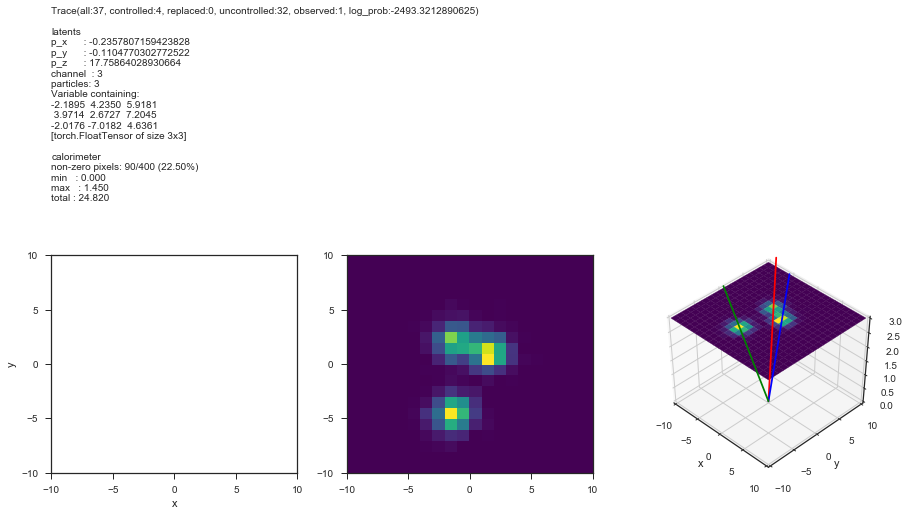

In [23]:
ground_truth_trace = next(model._trace_generator())
plot_trace(ground_truth_trace)

We run inference in the model, conditioning on the calorimeter output from `ground_truth_trace`.

In [25]:
posterior_metropolis_hastings = infer(ground_truth_trace, 1000, inference_engine=InferenceEngine.RANDOM_WALK_METROPOLIS_HASTINGS)

Time spent  | Time remain.| Progress             | Trace     | Accepted|Smp reuse| Traces/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 1000/1000 |  45.50% |  90.51% | 94.26       


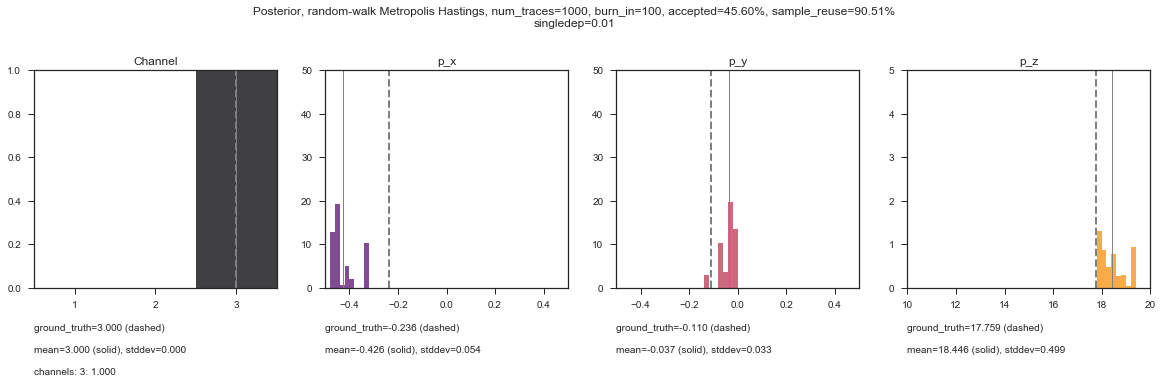

In [26]:
plot_distribution(posterior_metropolis_hastings, title='{}\nsingledep={}'.format(posterior_metropolis_hastings.name, model._singledep), ground_truths = [ground_truth_trace.result[1], ground_truth_trace.result[0][0], ground_truth_trace.result[0][1], ground_truth_trace.result[0][2]])

## Inference with importance sampling

Run inference with regular importance sampling (i.e., make proposals from the prior)

In [27]:
posterior_importance_sampling = infer(ground_truth_trace, 1000, inference_engine=InferenceEngine.IMPORTANCE_SAMPLING)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:04 | 0d:00:00:00 | #################### | 1000/1000 | 227.81       


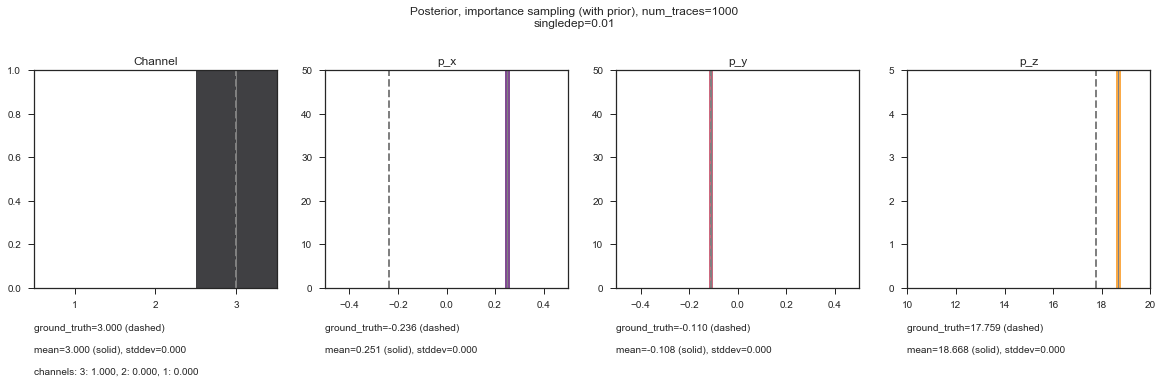

In [28]:
plot_distribution(posterior_importance_sampling, title='{}\nsingledep={}'.format(posterior_importance_sampling.name, model._singledep), ground_truths = [ground_truth_trace.result[1], ground_truth_trace.result[0][0], ground_truth_trace.result[0][1], ground_truth_trace.result[0][2]])

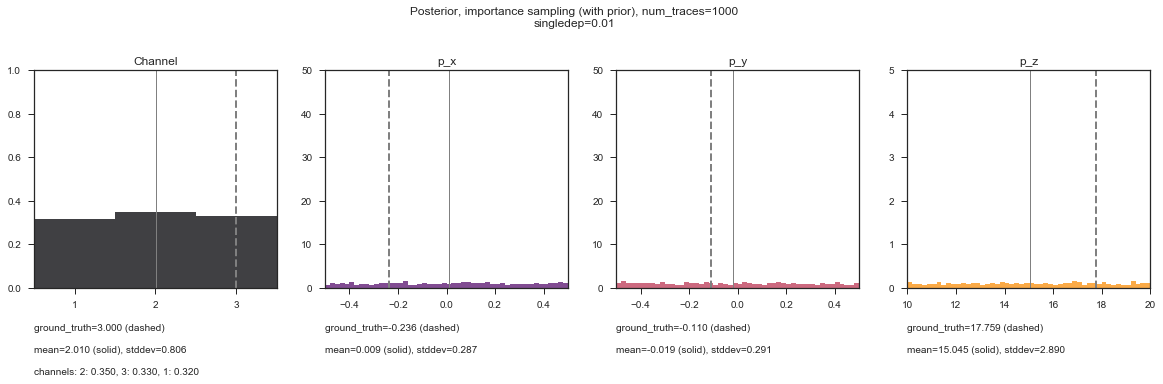

In [29]:
plot_distribution(posterior_importance_sampling.unweighted(), title='{}\nsingledep={}'.format(posterior_importance_sampling.name, model._singledep), ground_truths = [ground_truth_trace.result[1], ground_truth_trace.result[0][0], ground_truth_trace.result[0][1], ground_truth_trace.result[0][2]])

## Inference with inference compilation

Train inference network

In [30]:
# pyprob.set_cuda(True)
# model._inference_network = None
model.learn_inference_network(num_traces=200, observe_embedding=pyprob.nn.ObserveEmbedding.CONVNET_2D_5C, observe_reshape=[20,20])

Creating new inference network...
Polymorphing, new layers for address (1): 16/forward.?_Categorical(length_categori...
Polymorphing, new layers for address (2): 40/forward.?_Uniform_1
Polymorphing, new layers for address (3): 54/forward.?_Uniform_1
Polymorphing, new layers for address (4): 68/forward.?_Uniform_1
Polymorphing, new trainable params: 6,595,177
Train. time | Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Traces/sec
0d:00:00:03 | 256       | +4.25e+00 | +3.73e+00 | +3.73e+00 | 0d:00:00:00 | 78.0


Run inference using proposals from the trained inference network

In [31]:
posterior_inference_compilation = infer(ground_truth_trace, 1000, inference_engine=InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:19 | 0d:00:00:00 | #################### | 1000/1000 | 50.27       


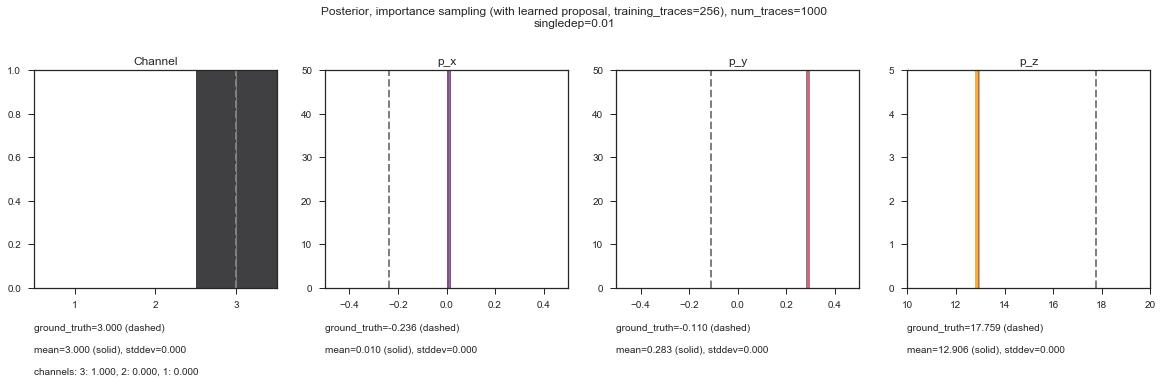

In [32]:
plot_distribution(posterior_inference_compilation, title='{}\nsingledep={}'.format(posterior_inference_compilation.name, model._singledep), ground_truths = [ground_truth_trace.result[1], ground_truth_trace.result[0][0], ground_truth_trace.result[0][1], ground_truth_trace.result[0][2]])

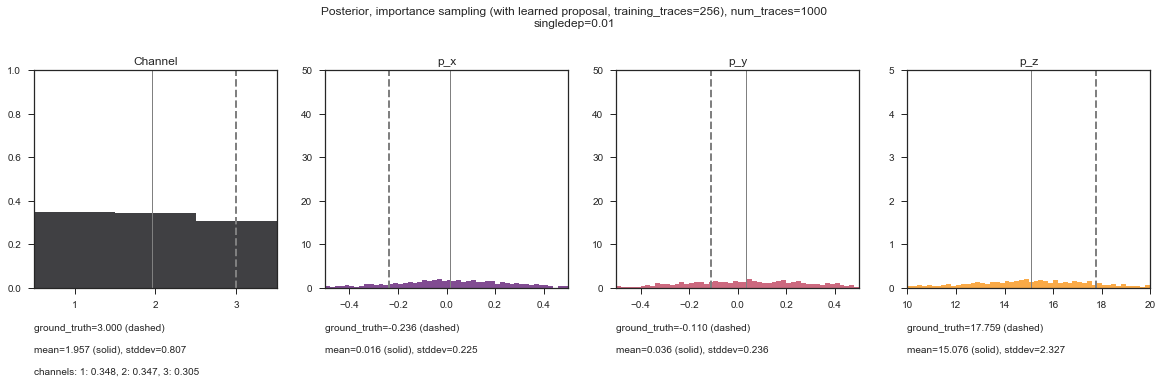

In [33]:
plot_distribution(posterior_inference_compilation.unweighted(), title='{}\nsingledep={}'.format(posterior_inference_compilation.name, model._singledep), ground_truths = [ground_truth_trace.result[1], ground_truth_trace.result[0][0], ground_truth_trace.result[0][1], ground_truth_trace.result[0][2]])